In [25]:
# Import necessary libraries
import os
import re
from scipy.stats import ttest_ind, f_oneway, sem, t
import json
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np

## Utility Functions for statistical analysis

In [26]:
# Statistical Analysis Functions
def perform_t_test(df, metric):
    original = df[df['supervision_type'] == 'original'][metric]
    fine_tuned = df[df['supervision_type'] == 'fine-tuned'][metric]
    t_stat, p_value = ttest_ind(original, fine_tuned)
    print(f"T-test for {metric}: t-statistic={t_stat}, p-value={p_value}")

In [27]:
def perform_anova(df, metric):
    models = df['model_name'].unique()
    model_groups = [df[df['model_name'] == model][metric] for model in models]
    f_stat, p_value = f_oneway(*model_groups)
    print(f"ANOVA for {metric}: F-statistic={f_stat}, p-value={p_value}")

In [28]:
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2., n-1)
    return mean - h, mean + h

## Utility Functions for Data Processing

In [29]:
# Function to filter based on model, task, and subfolder
def filter_data(df, selected_models=None, selected_tasks=None, selected_subfolders=None):
    if selected_models:
        df = df[df['model_name'].isin(selected_models)]
    if selected_tasks:
        df = df[df['task_type'].isin(selected_tasks)]
    if selected_subfolders:
        df = df[df['subfolder_type'].isin(selected_subfolders)]
    return df

In [30]:
# Function to normalize only the layers
def normalize_layers(df, layer_column='start_layer'):
    normalized_data = []
    
    models = df['model_name'].unique()
    
    for model in models:
        model_data = df[df['model_name'] == model]
        
        for supervision in model_data['supervision_type'].unique():
            supervision_data = model_data[model_data['supervision_type'] == supervision]
            
            for task in supervision_data['task_type'].unique():
                task_data = supervision_data[supervision_data['task_type'] == task]
                
                layers = task_data[layer_column].unique()
                layers.sort()

                max_layer = layers[-1]
                
                # Normalize layer position
                task_data['normalized_layer_position'] = task_data[layer_column].apply(lambda x: (x / max_layer) * 100)
                
                normalized_data.append(task_data)
    
    return pd.concat(normalized_data)

In [869]:
def clean_model_name(name):
    """
    Clean and format model names for better readability
    """
    # Dictionary of specific model name replacements
    model_name_map = {
        'GPT2_original': 'GPT2_S org',
        'GPT2_tuned': 'GPT2_S FT',
        # 'GPT2_carma': 'GPT2_S CFT (4)',
        'GPT2_carma': 'GPT2_S CARMA',
        'GPT2_medium_original': 'GPT2_M org', 
        'GPT2_medium_tuned': 'GPT2_M FT',
        'GPT2_medium_carma': 'GPT2_M CARMA',
        # 'GPT2_medium_carma_5': 'GPT2 M CFT (5)',
        'GPT2_medium_carma_5': 'GPT2_M CARMA',
        # 'GPT2_medium_carma_4': 'GPT2 M CFT (4)',
        'GPT2_medium_carma_4': 'GPT2_M CARMA',
        'GPT2_large': 'GPT2_L org',
        'GPT2_large_tuned': 'GPT2_L FT',
        'GPT2_large_original': 'GPT2_L',
        'GPT2_large_carma': 'GPT2_L CARMA',
        'GPT2_large_carma1': 'GPT2_L CARMA',
        'GPT2_xl': 'GPT2 XL',
        'gpt2-small': 'GPT2 S',
        'gpt2-medium': 'GPT2 M',
        'gpt2-large': 'GPT2 L',
        'gpt2-xl': 'GPT2 XL',
        'Gemma_2B_original': 'Gemma_2B org',
        'Gemma_2B_tuned': 'Gemma_2B FT',
        'Gemma_2B_carma_7': 'Gemma_2B CFT (7)',
        'Gemma_2B_carma_10': 'Gemma 2B CFT (10)',
        'Gemma_2B_carma_12': 'Gemma 2B CFT (12)',
        'Gemma_2B_carma_2': 'Gemma_2B CARMA',
        'GPT2_carma_sst_2' : 'GPT2 S CFT (2)',
        'GPT2_carma_sst_1' : 'GPT2 S CFT (1)',
        'GPT2_tuned_sst' : 'GPT2 S FT SST',
    }
    
    # Return mapped name if exists, otherwise do some basic cleaning
    if name in model_name_map:
        return model_name_map[name]
    
    # General cleaning
    return (name.replace('_', ' ')
                .replace('gpt2', 'GPT2')
                .title())

In [870]:
def clean_column_names(column):
    """
    Clean and format column names for better readability
    """
    column_name_map = {
        'model_name': 'Model Name',
        'supervision_type': 'Supervision Type',
        'normalized_layer_position': 'Normalized Layer Position',
        'avg_grouped_accuracy': 'Average Grouped Accuracy',
        'grouping_protocol': 'Grouping Protocol'
    }
    
    # Return mapped name if exists, otherwise do basic cleaning
    if column in column_name_map:
        return column_name_map[column]
    
    # General cleaning
    return column.replace('_', ' ').title()

In [871]:
def extract_avg_metrics_from_json(json_file_path):
    """Extract average metrics from a JSON file."""
    with open(json_file_path, 'r') as file:
        json_data = json.load(file)
    
    # Handle both list and dictionary json structures
    if isinstance(json_data, list):
        avg_metrics = json_data[-1]['summary'] if json_data and 'summary' in json_data[-1] else None
    elif isinstance(json_data, dict):
        avg_metrics = json_data.get('summary', json_data)
    else:
        return None
    
    if avg_metrics:
        return {
            'model_name': avg_metrics.get('model_name', 'Unknown'),
            'avg_clean_accuracy': avg_metrics.get('avg_clean_accuracy'),
            'avg_grouped_accuracy': avg_metrics.get('avg_grouped_accuracy'),
            'avg_clean_f1': avg_metrics.get('avg_clean_f1'),
            'avg_grouped_f1': avg_metrics.get('avg_grouped_f1'),
            'avg_clean_semantic_similarity': avg_metrics.get('avg_clean_semantic_similarity'),
            'avg_grouped_semantic_similarity': avg_metrics.get('avg_grouped_semantic_similarity'),
            'std_clean_accuracy': avg_metrics.get('std_clean_accuracy'),
            'std_grouped_accuracy': avg_metrics.get('std_grouped_accuracy'),
            'granularity': avg_metrics.get('granularity'),
            'grouping_protocol': avg_metrics.get('grouping_protocol'),
            'task_type': 'sst',
            'supervision_type': 'fine-tuned',
        }
    
    return None

In [872]:
def process_multiple_base_directories(base_directories):
    """
    Process JSON files from multiple base directories.
    
    Args:
        base_directories (dict): Dictionary of {base_directory: column_name}
    
    Returns:
        pd.DataFrame: Combined DataFrame of metrics
    """
    all_dataframes = []
    
    for base_dir, column_name in base_directories.items():
        folder_metrics = []
        # Iterate through JSON files in the base directory
        print(f"Processing base directory: {base_dir}")
        for filename in os.listdir(base_dir):
            if filename.endswith('.json') and not filename.startswith('._'):
                file_path = os.path.join(base_dir, filename)
                # print(f"Processing {file_path}...")
                metrics = extract_avg_metrics_from_json(file_path)
                
                if metrics:
                    # Add the custom column
                    metrics['file_name'] = file_path.split('/')[-1]
                    metrics['model_name'] = column_name
                    metrics['start_layer'] = int(re.search(r'starting_(\d+)', file_path).group(1))
                    if 'original' in file_path or 'original' in column_name:
                        metrics['supervision_type'] = 'original'
                    # elif 'original' in column_name:
                    #     metrics['supervision_type'] = 'fine-tuned'
                    folder_metrics.append(metrics)
                    # llm_evaluation_results_GPT2_carma_tuned_20241119_105156_fine_tuned_idm_seed_42_sum_20241121_083517_starting_11.json
                    
        
        # Create DataFrame for this base directory
        df = pd.DataFrame(folder_metrics)
        all_dataframes.append(df)
    
    # Combine all DataFrames
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    
    return combined_df

In [873]:
def average_protocols(df, group_by=['model_name', 'start_layer', 'supervision_type', 'task_type', 'granularity'], metrics=['avg_clean_accuracy', 'avg_grouped_accuracy','avg_clean_f1', 'avg_grouped_f1', 'avg_clean_semantic_similarity','avg_grouped_semantic_similarity', 'std_clean_accuracy','std_grouped_accuracy']):
    """
    Compute the mean and standard deviation of the specified metrics, grouped by the provided keys.
    
    Args:
        df (pandas.DataFrame): The input dataframe.
        group_by (list): The columns to group the dataframe by.
        metrics (list): The columns to compute the mean and standard deviation for.
    
    Returns:
        pandas.DataFrame: The aggregated dataframe.
    """
    # Compute the mean and standard deviation for each group
    new_df = df.groupby(group_by)[metrics].agg(['mean', 'std']).reset_index()
    
    # Rename the columns for better readability
    new_columns = [f'{metric}_{agg}' for metric in metrics for agg in ['mean', 'std']]
    new_df.columns = group_by + new_columns
    
    return new_df

## Utility Functions for Plotting

In [874]:
# Plotting function for normalized layers
def plot_normalized_layers(df, metric='avg_grouped_accuracy', filter_supervision=None, task_type=None, grouping_protocol='sum'):
    if filter_supervision:
        df = df[df['supervision_type'] == filter_supervision]
    if grouping_protocol:
        df = df[df['grouping_protocol'] == grouping_protocol]
    
    plt.figure(figsize=(6, 4), dpi=150)
    sns.lineplot(x='normalized_layer_position', y=metric, hue='model_name', style='supervision_type', data=df, markers=True)
    # sns.scatterplot(x='normalized_layer_position', y=metric, hue='model_name', style='supervision_type', data=df,)
    
    plt.xticks([0, 25, 50, 75, 100], ['0%', '25%', '50%', '75%', '100%'])
    
    plt.xlabel('Normalised Layer Position')
    plt.ylabel(f'{metric.replace("_", " ").title()}')
    if grouping_protocol:
        plt.title(f'(IDM) {grouping_protocol.title()}')
    else:
        plt.title('Layer-wise Comparison Means of Protocols')
    # plt.title(f'Layer-wise {metric.replace("_", " ").title()} Comparison (Normalised Layers) - (IDM) {grouping_protocol.title()}')

    # plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, frameon=False)
    plt.tight_layout()
    save_path = f'../plots/layer_wise_{metric}_comparison.pdf'
    plt.savefig(save_path)
    plt.show()

In [875]:
def plot_normalized_layers_improved(df, 
                            metric='avg_grouped_accuracy', 
                            filter_supervision=None, 
                            task_type=None, 
                            grouping_protocol='sum'):
    # Create a copy of the dataframe and apply name cleaning
    plot_df = df.copy()
    
    # Clean model names
    plot_df['model_name'] = plot_df['model_name'].apply(clean_model_name)
    
    # Filter dataframe based on input parameters
    if filter_supervision:
        plot_df = plot_df[plot_df['supervision_type'] == filter_supervision]
    if grouping_protocol:
        plot_df = plot_df[plot_df['grouping_protocol'] == grouping_protocol]
    
    # Create a figure optimized for A4 document
    plt.figure(figsize=(6, 3), dpi=250)
    
    # Use a color-blind friendly palette with fewer colors
    palette = sns.color_palette("colorblind", n_colors=len(plot_df['model_name'].unique()))
    
    # Create the plot with more compact styling
    plt.xlabel(clean_column_names('normalized_layer_position'), fontsize=9)
    plt.ylabel(clean_column_names(metric), fontsize=9)
    
    # Plot with reduced complexity
    sns.lineplot(
        x='normalized_layer_position', 
        y=metric, 
        hue='model_name', 
        style='supervision_type', 
        data=plot_df,
        markers=True,
        palette=palette,
        linewidth=1.5,
        markersize=4
    )
    
    # Customize x-axis ticks
    plt.xticks([0, 25, 50, 75, 100], ['0%', '25%', '50%', '75%', '100%'], fontsize=8)
    plt.yticks(fontsize=8)
    
    # Add subtle grid
    plt.grid(True, linestyle='--', linewidth=0.4, color='lightgray')
    
    # Compact title
    if grouping_protocol:
        plt.title(f'Layer-wise Performance: {clean_column_names(grouping_protocol)}', fontsize=10)
    else:
        plt.title('Layer-wise Performance', fontsize=10)
    
    # Compact legend
    plt.legend(
        title='Model & Supervision', 
        title_fontsize=8,
        fontsize=7,
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        borderaxespad=0,
        frameon=False
    )
    
    # Adjust layout
    plt.tight_layout()
    
    # Save for A4 document
    save_path = f'../plots/layer_wise_{metric}_comparison_a4.pdf'
    plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

In [876]:
def plot_heatmap(df, metric='avg_grouped_accuracy', grouping_protocol='sum'):
    if grouping_protocol:
        df = df[df['grouping_protocol'] == grouping_protocol]
    
    pivot_table = df.pivot_table(
        index='model_name', 
        columns='normalized_layer_position', 
        values=metric, 
        aggfunc='mean'
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pivot_table, 
        annot=True, 
        cmap='YlGnBu', 
        fmt='.2f', 
        linewidths=0.5
    )
    
    plt.xlabel('Normalized Layer Position')
    plt.ylabel('Model Name')
    plt.title(f'{metric.replace("_", " ").title()} Heatmap (IDM - {grouping_protocol.title()})', fontsize=14)
    plt.tight_layout()
    plt.show()

In [877]:
def plot_normalized_layers_improved_grid(df, 
                                         metric='avg_grouped_accuracy', 
                                         filter_supervision=None, 
                                         task_type=None):
    # Define the grouping protocols and set up the grid
    grouping_protocols = ['mean', 'max', 'sum']
    
    # Map column names for display in the legend
    legend_title_mapping = {
        'model_name': 'Model name',
        'supervision_type': 'Supervision type'
    }
    
    # Create a figure with GridSpec for better control over layout
    fig = plt.figure(figsize=(15, 4), dpi=150)  # Reduced height of the figure
    gs = GridSpec(2, len(grouping_protocols), height_ratios=[3, 0.5], hspace=0.5)  # Compact layout
    
    # Iterate over the grouping protocols and axes
    axes = []
    for i, grouping_protocol in enumerate(grouping_protocols):
        ax = fig.add_subplot(gs[0, i])  # Place each plot in the first row
        axes.append(ax)
        
        # Create a copy of the dataframe and apply name cleaning
        plot_df = df.copy()
        plot_df['model_name'] = plot_df['model_name'].apply(clean_model_name)
        
        # Filter dataframe based on grouping protocol
        plot_df = plot_df[plot_df['grouping_protocol'] == grouping_protocol]
        
        # Use a color-blind friendly palette with fewer colors
        print(plot_df['model_name'].unique())
        palette = sns.color_palette("colorblind", n_colors=len(plot_df['model_name'].unique()))
        
        # Plot on the current axis
        sns.lineplot(
            x='normalized_layer_position', 
            y=metric, 
            hue='model_name', 
            style='supervision_type', 
            data=plot_df,
            markers=True,
            palette=palette,
            linewidth=1.5,
            markersize=4,
            ax=ax  # Specify the current axis
        )
        
        # Customize the current subplot
        ax.set_title(f'{grouping_protocol.capitalize()} CAP', fontsize=12)
        ax.set_xlabel('Normalised Layer Position', fontsize=10)
        ax.set_ylabel(metric.replace('_', ' ').capitalize(), fontsize=10)
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=9)
        ax.tick_params(axis='y', labelsize=9)
        ax.grid(True, linestyle='--', linewidth=0.4, color='lightgray')
    
    # Create a combined legend below the plots
    handles, labels = axes[0].get_legend_handles_labels()  # Extract legend from the first plot
    fig.legend(
        handles, 
        labels, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.1),  # Bring legend closer to the plots
        fontsize=9,  # Increased font size
        ncol=3, 
        frameon=False,
        title=f"{legend_title_mapping['model_name']} & {legend_title_mapping['supervision_type']}"
    )
    
    # Remove individual legends from the subplots
    for ax in axes:
        ax.get_legend().remove()
    
    # Adjust layout and save the entire grid
    plt.tight_layout(rect=[0, 0.15, 1, 1])  # Reduced space for the legend
    save_path = f'../plots/layer_wise_{metric}_comparison_grid_with_bottom_legend_1.png'
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [878]:
def plot_normalized_layers_improved_grid_grouped_color(df, 
                                         metric='avg_grouped_accuracy', 
                                         filter_supervision=None, 
                                         task_type=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.gridspec import GridSpec
    from matplotlib.colors import to_rgba

    # Define the grouping protocols and set up the grid
    grouping_protocols = ['mean', 'max', 'sum']
    
    # Create a figure with GridSpec for better control over layout
    fig = plt.figure(figsize=(15, 4), dpi=150)
    gs = GridSpec(2, len(grouping_protocols), height_ratios=[3, 0.5], hspace=0.5)
    
    # Clean model names before extraction
    df['model_name'] = df['model_name'].apply(clean_model_name)
    
    # Extract family and variation directly
    df['model_family'] = df['model_name'].str.split(' ').str[0]  # First split as family name
    df['model_variation'] = df['model_name'].str.split(' ').str[1:].str.join(' ')  # Rest as variation

    # Dynamically assign colors and line styles
    families = df['model_family'].unique()
    variations = df['model_variation'].unique()
    
    # Assign base colors to families
    family_colors = sns.color_palette("tab10", n_colors=len(families))
    family_color_mapping = dict(zip(families, family_colors))
    
    # Define intensity levels for variations
    intensity_levels = [0.6, 0.8, 1.0]  # Adjust these values for lighter/darker shades
    variation_intensity_mapping = dict(zip(variations, intensity_levels * (len(variations) // len(intensity_levels) + 1)))
    
    # Assign line styles to variations
    line_styles = ['-', '--', '-.', ':']
    variation_line_mapping = dict(zip(variations, line_styles * (len(variations) // len(line_styles) + 1)))
    
    # Iterate over the grouping protocols and axes
    axes = []
    for i, grouping_protocol in enumerate(grouping_protocols):
        ax = fig.add_subplot(gs[0, i])
        axes.append(ax)
        
        # Filter dataframe based on grouping protocol
        plot_df = df[df['grouping_protocol'] == grouping_protocol]
        
        # Plot each family and variation
        for family, family_df in plot_df.groupby('model_family'):
            base_color = family_color_mapping.get(family, (0.5, 0.5, 0.5))  # Default to gray if missing
            for variation, variation_df in family_df.groupby('model_variation'):
                # Adjust color intensity for variation
                color_with_intensity = to_rgba(base_color, variation_intensity_mapping.get(variation, 1.0))
                sns.lineplot(
                    x='normalized_layer_position', 
                    y=metric, 
                    data=variation_df,
                    label=f'{family} {variation}', 
                    color=color_with_intensity,
                    linestyle=variation_line_mapping.get(variation, '-'), 
                    linewidth=1.5,
                    ax=ax
                )
        
        # Customize the subplot
        ax.set_title(f'{grouping_protocol.capitalize()} CAP', fontsize=12)
        ax.set_xlabel('Normalized Layer Position', fontsize=10)
        ax.set_ylabel(metric.replace('_', ' ').capitalize(), fontsize=10)
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=9)
        ax.tick_params(axis='y', labelsize=9)
        ax.grid(True, linestyle='--', linewidth=0.4, color='lightgray')
    
    # Create a combined legend below the plots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, 
        labels, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.1), 
        fontsize=9, 
        ncol=3, 
        frameon=False
    )
    
    # Remove individual legends from the subplots
    for ax in axes:
        ax.get_legend().remove()
    
    # Adjust layout and save the entire grid
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    save_path = f'../plots/layer_wise_{metric}_comparison_grid_with_bottom_legend.png'
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [879]:
def create_grouped_bar_chart(models, original, task_fine_tuned, all_fine_tuned, colors, output_file):
    """
    Creates and saves a grouped bar chart comparing original, task fine-tuned, and all fine-tuned model results.

    Parameters:
    - models (list): List of model names.
    - original (list): Data for original model predictions.
    - task_fine_tuned (list): Data for task fine-tuned model predictions.
    - all_fine_tuned (list): Data for all fine-tuned model predictions.
    - colors (list): List of colors for each bar group.
    - output_file (str): Path to save the plot as a PDF file.

    Returns:
    - None
    """
    x = np.arange(len(models))  # the label locations
    width = 0.25  # the width of the bars

    # Create the grouped bar chart
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, original, width, label='Original', color=colors[0])
    bars2 = ax.bar(x, task_fine_tuned, width, label='Task Fine-Tuned', color=colors[1])
    bars3 = ax.bar(x + width, all_fine_tuned, width, label='CARMA Fine-Tuned', color=colors[2])

    # Add labels, title, and legend
    ax.set_xlabel('Models')
    ax.set_ylabel('Number of Correct Predictions')
    ax.set_title('Comparison of Correct Predictions Across Models')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    # Style adjustments for a clean, professional look
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_file, format='pdf')
    plt.show()

## Plotting and Analysis

In [880]:
base_directories_cleaned_idm = {
    # '/Users/user/Desktop/Year 2/Project 6  Controlled Compositionality in LLMs/Code/results/GPT2/idm/cap_results/tw_logs': 'GPT2_original',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_tw_tuned_20241120_133648/idm/cap_results/tw_logs': 'GPT2_tuned',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_carma_tuned_20241119_105156/idm/cap_results/tw_logs': 'GPT2_carma',
    
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/GPT2_medium/idm/cap_results/tw_logs': 'GPT2_medium_original',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_tw_tuned_20241120_134429/idm/cap_results/tw_logs': 'GPT2_medium_tuned',
    # '/Volumes/NURA_EXT_2/results/results/GPT2_medium_tw_carma_tuned_20241124_082645/idm/cap_results/tw_logs' : 'GPT2_medium_carma7',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_carma_tw_tuned_20241122_111457/idm/cap_results/tw_logs': 'GPT2_medium_carma_5',
    
    
    # '/Volumes/NURA_EXT_2/results/results/GPT2_large_original/idm/tw_logs': 'GPT2_large_original',
    # '/Volumes/NURA_EXT_2/results/results/GPT2_large_tw_tuned_20241121_124651/idm/tw_logs' : 'GPT2_large_tuned',
    # '/Volumes/NURA_EXT_2/results/results_1/GPT2_large_tw_carma_tuned_20241121_114544/idm/tw_logs' : 'GPT2_large_carma1',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_large_tw_carma_tuned_20241217_182904/idm/cap_results/tw_logs' : 'GPT2_large_carma2',
    # 
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_original/idm/cap_results/tw_logs': 'Gemma_2B_original',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_tuned_20241128_152405/idm/cap_results/tw_logs': 'Gemma_2B_tuned',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_carma_tuned_20241129_160939/idm/cap_results/tw_logs': 'Gemma_2B_carma1',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_carma_tuned_20241129_104548/idm/cap_results/tw_logs': 'Gemma_2B_carma_2',
    
    
}

In [881]:
base_directories_cleaned_sst = {
    # '/Volumes/NURA_EXT_2/results/results/GPT2_tw_tuned_20241212_232526/sst/cap_results/tw_logs': 'GPT2_tuned',
    '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/sst/GPT2_tw_tuned_20241212_232526/sst/cap_results/tw_logs': 'GPT2_tuned', ##
    # '/Volumes/NURA_EXT_2/results/results/GPT2_tw_carma_tuned_20241212_224056/sst/cap_results/tw_logs': 'GPT2_carma1',
    '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/sst/GPT2_tw_carma_tuned_20241212_224056/sst/cap_results/tw_logs': 'GPT2_carma', ##
    # '/Volumes/NURA_EXT_2/results/results/GPT2_tw_carma_tuned_20241212_231146/sst/cap_results/tw_logs': 'GPT2_carma2',
    # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/sst/GPT2_tw_carma_tuned_20241212_231146/sst/cap_results/tw_logs': 'GPT2_carma2',
    
    ## Extermly bad    
    # '/Volumes/NURA_EXT_2/results/results/GPT2_medium_tw_carma_tuned_20241213_004258/sst/cap_results/tw_logs': 'GPT2_medium_carma_1',
    '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_tw_carma_tuned_20241219_162138/sst/cap_results/tw_logs': 'GPT2_medium_carma', #1710 ##
    '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_tw_tuned_20241219_153648/sst/cap_results/tw_logs': 'GPT2_medium_tuned', #1730 ##
    
    
    # '/Volumes/NURA_EXT_2/results/results/GPT2_large_tw_tuned_20241213_004440/sst/cap_results/tw_logs': 'GPT2_large_tuned_sst',
    '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/sst/GPT2_large_tw_tuned_20241213_004440/sst/cap_results/tw_logs': 'GPT2_large_tuned', ##
    # '/Volumes/NURA_EXT_2/results/results/GPT2_large_tw_carma_tuned_20241212_232123/sst/cap_results/tw_logs' : 'GPT2_large_carma1',
    '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/sst/GPT2_large_tw_carma_tuned_20241212_232123/sst/cap_results/tw_logs' : 'GPT2_large_carma', ##
    # '/Volumes/NURA_EXT_2/results/results/GPT2_large_tw_carma_tuned_20241212_215012/sst/cap_results/tw_logs' : 'GPT2_large_carma2',
    # '/Volumes/NURA_EXT_2/results/results/GPT2_large_tw_carma_tuned_20241212_215012/sst/cap_results/tw_logs' : 'GPT2_large_carma2',
    # 

    
    
}

In [882]:
base_directories = {
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_carma_tuned_20241119_105156/idm/cap_results/tw_logs': 'GPT2_carma',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_tw_tuned_20241120_133648/idm/cap_results/tw_logs': 'GPT2_tuned',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_original/idm/cap_results/tw_logs':'GPT2_original',
        # '/Users/user/Desktop/Year 2/Project 6  Controlled Compositionality in LLMs/Code/results/GPT2/idm/cap_results/tw_logs':'GPT2_original',
        # '/Volumes/NURA_EXT_2/results/results/GPT2_tw_tuned_20241212_232526/sst/cap_results/tw_logs': 'GPT2_tuned_sst',
        # '/Volumes/NURA_EXT_2/results/results/GPT2_tw_carma_tuned_20241212_231146/sst/cap_results/tw_logs': 'GPT2_carma_sst_1',
        # '/Volumes/NURA_EXT_2/results/results/GPT2_tw_carma_tuned_20241212_224056/sst/cap_results/tw_logs': 'GPT2_carma_sst_2',
        # 
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_original/idm/cap_results/tw_logs':'GPT2_medium_original',
        # '/Users/user/Desktop/Year 2/Project 6  Controlled Compositionality in LLMs/Code/results/GPT2_medium/idm/cap_results/tw_logs':'GPT2_medium_original',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_tw_carma_tuned_20241120_204822/idm/cap_results/tw_logs': 'GPT2_medium_carma_4',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_tw_tuned_20241120_134429/idm/cap_results/tw_logs': 'GPT2_medium_tuned',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_carma_tw_tuned_20241122_111457/idm/cap_results/tw_logs': 'GPT2_medium_carma_5',
    # '/Volumes/NURA_EXT_2/results/results/GPT2_medium_tw_carma_tuned_20241124_082645/idm/cap_results/tw_logs': 'GPT2_medium_carma_7',
        # 
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_large_tw_carma_tuned_20241121_114544/idm/cap_results/tw_logs': 'GPT2_large_carma',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_large_tw_tuned_20241121_124651/idm/cap_results/tw_logs': 'GPT2_large_tuned',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_large_original/idm/cap_results/tw_logs': 'GPT2_large_original',
        '/Volumes/NURA_EXT_2/results/results_1/gemma_2b_tw_tuned_20241202_114745_fine_tuned/cap_results/idm': 'Gemma_2B_tuned2',
            '/Volumes/NURA_EXT_2/results/results/gemma_2b_tw_carma_tuned_20241217_223500/idm/cap_results/tw_logs': 'Gemma_2B_carma4',
# '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_carma_tuned_20241128_123355/idm/cap_results/tw_logs': 'Gemma_2B_carma3',
        '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_original/idm/cap_results/tw_logs': 'Gemma_2B_original',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_tuned_20241128_152405_fine_tuned/idm/cap_results/tw_logs': 'Gemma_2B_tuned',
    '/Volumes/NURA_EXT_2/results/results_1/gemma_2b_tw_tuned_20241128_152405_fine_tuned/cap_results/idm': 'Gemma_2B_tuned',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_carma_tuned_20241128_123355_fine_tuned/idm/cap_results/tw_logs': 'Gemma_2B_carma_7',
    '/Volumes/NURA_EXT_2/results/results_1/gemma_2b_tw_carma_tuned_20241128_123355_fine_tuned/cap_results/idm': 'Gemma_2B_carma_7',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_carma_tuned_20241129_104548_fine_tuned/idm/cap_results/tw_logs': 'Gemma_2B_carma_10',
    '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_tuned_20241202_114745/idm/cap_results/tw_logs': 'Gemma_2B_tuned1',
    '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_tuned_20241128_152405/idm/cap_results/tw_logs': 'Gemma_2B_tuned2',
    '/Volumes/NURA_EXT_2/results/results_1/gemma_2b_tw_carma_tuned_20241129_104548_fine_tuned/cap_results/idm': 'Gemma_2B_carma_10',
        # '/Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/gemma_2b_tw_carma_tuned_20241129_160939_fine_tuned/idm/cap_results/tw_logs': 'Gemma_2B_carma_12', # carma_weight 0.5 --mi_end_layer 12 --stability_end_layer 12
    # '/Volumes/NURA_EXT_2/results/results_1/gemma_2b_tw_carma_tuned_20241129_160939_fine_tuned/cap_results/idm': 'Gemma_2B_carma_12',
    # '/Volumes/NURA_EXT_2/results/results/gemma_2b_tw_carma_tuned_20241217_223500/idm/cap_results/tw_logs': 'Gemma_2B_carma_5',
    # '/Volumes/NURA_EXT_2/results/results/GPT2_medium_tw_carma_tuned_20241213_004258/sst/cap_results/tw_logs': 'GPT2_medium_carma_1',
    # '/Volumes/NURA_EXT_2/results/results/GPT2_medium_tw_carma_tuned_20241212_235805/sst/cap_results/tw_logs': 'GPT2_medium_carma_2',
    # '/Volumes/NURA_EXT_2/results/results/GPT2_medium_tw_tuned_20241212_234402/sst/cap_results/tw_logs': 'GPT2_medium_tuned_sst',
        
}

In [883]:
# Process metrics from all base directories
# metrics_df = process_multiple_base_directories(base_directories)
# metrics_df.head()
# metrics_df_idm = process_multiple_base_directories(base_directories_cleaned_idm)
metrics_df_sst = process_multiple_base_directories(base_directories_cleaned_sst)

Processing base directory: /Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/sst/GPT2_tw_tuned_20241212_232526/sst/cap_results/tw_logs
Processing base directory: /Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/sst/GPT2_tw_carma_tuned_20241212_224056/sst/cap_results/tw_logs
Processing base directory: /Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_tw_carma_tuned_20241219_162138/sst/cap_results/tw_logs
Processing base directory: /Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/server_results/GPT2_medium_tw_tuned_20241219_153648/sst/cap_results/tw_logs
Processing base directory: /Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/results/sst/GPT2_large_tw_tuned_20241213_004440/sst/cap_results/tw_logs
Processing base directory: /Volumes/NURA_EXT_2/Paper_4/Project_6_Controlled_Compositionality_in_LLMs/Code/result

In [884]:
metrics_df_sample1 = metrics_df[metrics_df['grouping_protocol'] == 'sum']
metrics_df_sample2 = metrics_df[metrics_df['grouping_protocol'] == 'mean']
metrics_df_sample = pd.concat([metrics_df_sample1, metrics_df_sample2])

In [885]:
# Perform statistical analysis
normalised_metrics_df = normalize_layers(metrics_df)
normalised_metrics_df_sample = normalize_layers(metrics_df_sample)
normalised_metrics_df_idm = normalize_layers(metrics_df_idm)
normalised_metrics_df_sst = normalize_layers(metrics_df_sst)
# plot_normalized_layers_improved(normalised_metrics_df_sample, metric='avg_grouped_accuracy', grouping_protocol='mean')

['GPT2_S FT' 'GPT2_S CARMA' 'GPT2_M CARMA' 'GPT2_M FT' 'GPT2_L FT'
 'GPT2_L CARMA']
['GPT2_S FT' 'GPT2_S CARMA' 'GPT2_M CARMA' 'GPT2_M FT' 'GPT2_L FT'
 'GPT2_L CARMA']
['GPT2_S FT' 'GPT2_S CARMA' 'GPT2_M CARMA' 'GPT2_M FT' 'GPT2_L FT'
 'GPT2_L CARMA']


/var/folders/gy/md6fclq90276s3zmv3dmcbqr0000gp/T/ipykernel_47692/3312777178.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])  # Reduced space for the legend


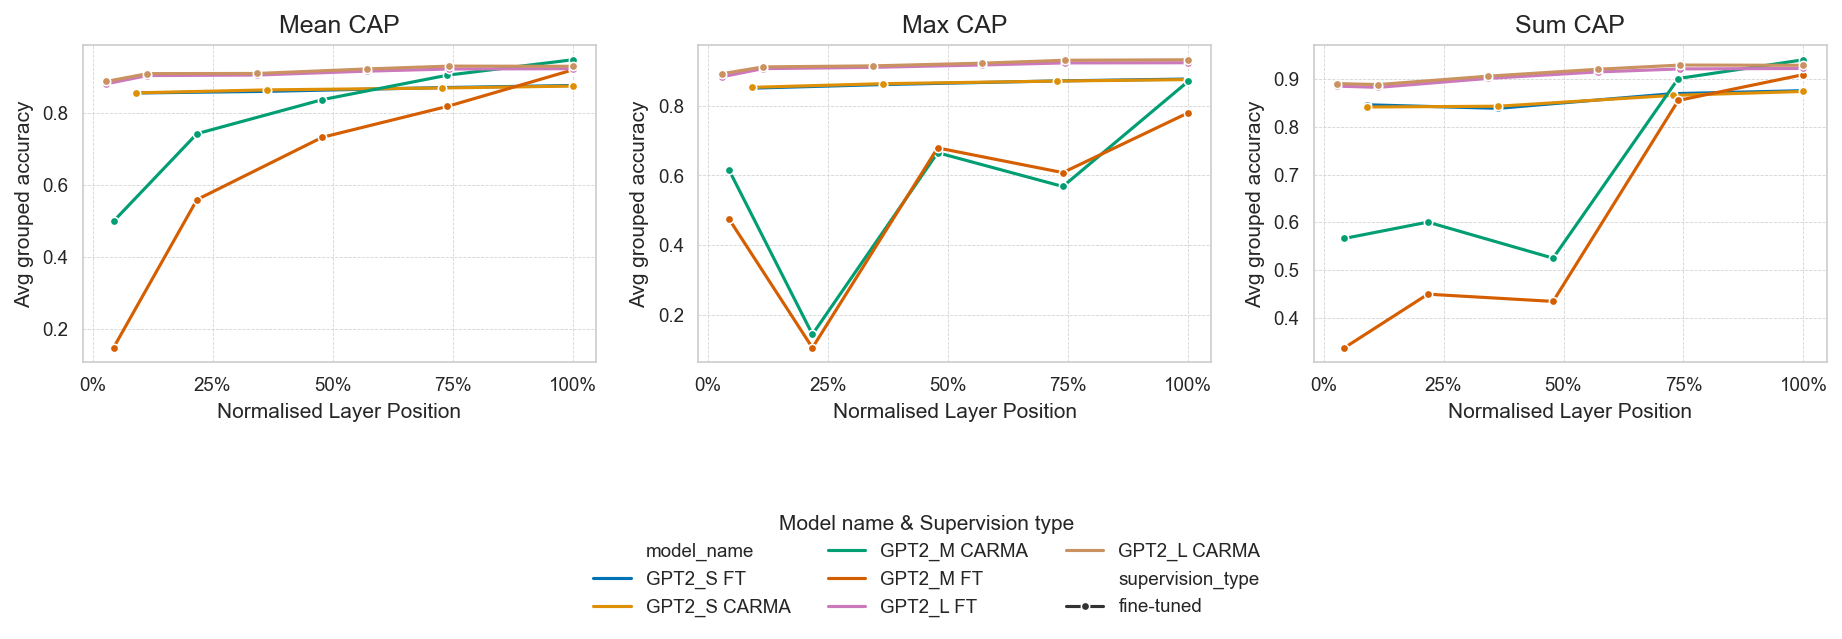

In [886]:
# Call the function to generate the grid plot
# plot_normalized_layers_improved_grid(normalised_metrics_df_idm, metric='avg_grouped_accuracy')
plot_normalized_layers_improved_grid(normalised_metrics_df_sst, metric='avg_grouped_accuracy')

/var/folders/gy/md6fclq90276s3zmv3dmcbqr0000gp/T/ipykernel_47692/389681926.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


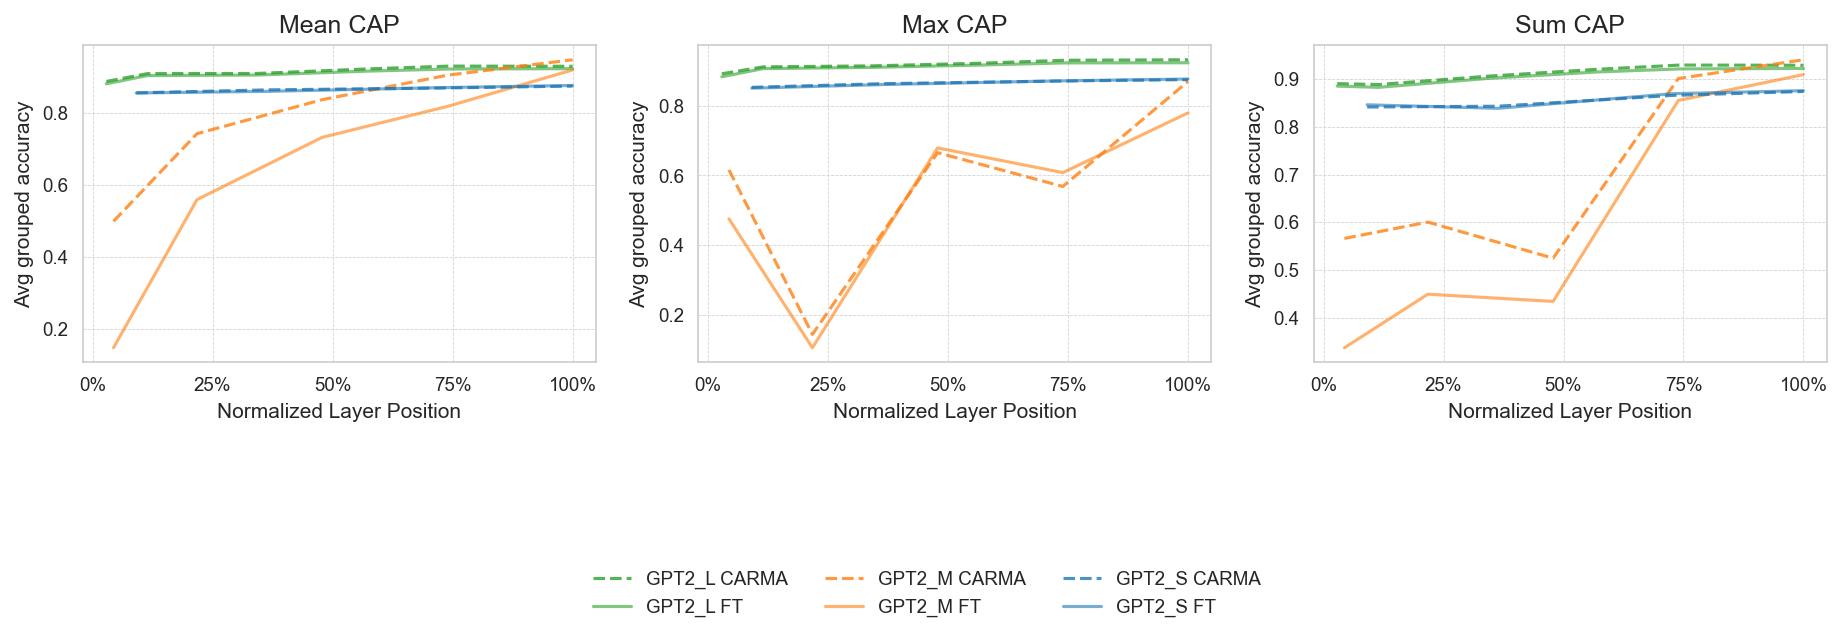

In [887]:
plot_normalized_layers_improved_grid_grouped_color(normalised_metrics_df_sst, metric='avg_grouped_accuracy')

In [755]:
metrics_df

,model_name,avg_clean_accuracy,avg_grouped_accuracy,avg_clean_f1,avg_grouped_f1,avg_clean_semantic_similarity,avg_grouped_semantic_similarity,std_clean_accuracy,std_grouped_accuracy,granularity,grouping_protocol,task_type,supervision_type,file_name,start_layer
0,Gemma_2B_tuned2,1.0,0.930827,1.0,0.930827,1.0,0.953787,0.0,0.137984,tw_logs,mean,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_tuned_20241...,12
1,Gemma_2B_tuned2,1.0,0.449014,1.0,0.449014,1.0,0.638149,0.0,0.234057,tw_logs,max,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_tuned_20241...,1
2,Gemma_2B_tuned2,1.0,0.718835,1.0,0.718835,1.0,0.815131,0.0,0.200626,tw_logs,max,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_tuned_20241...,4
3,Gemma_2B_tuned2,1.0,0.882180,1.0,0.882180,1.0,0.916261,0.0,0.149184,tw_logs,max,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_tuned_20241...,8
4,Gemma_2B_tuned2,1.0,0.889911,1.0,0.889911,1.0,0.924937,0.0,0.143465,tw_logs,max,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_tuned_20241...,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Gemma_2B_carma_10,1.0,0.811110,1.0,0.811110,1.0,0.885272,0.0,0.177871,tw_logs,sum,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_carma_tuned...,1
115,Gemma_2B_carma_10,1.0,0.880086,1.0,0.880086,1.0,0.930593,0.0,0.158285,tw_logs,sum,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_carma_tuned...,4
116,Gemma_2B_carma_10,1.0,0.910595,1.0,0.910595,1.0,0.949192,0.0,0.147866,tw_logs,sum,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_carma_tuned...,8
117,Gemma_2B_carma_10,1.0,0.918306,1.0,0.918306,1.0,0.953654,0.0,0.149803,tw_logs,sum,sst,fine-tuned,llm_evaluation_results_gemma_2b_tw_carma_tuned...,12


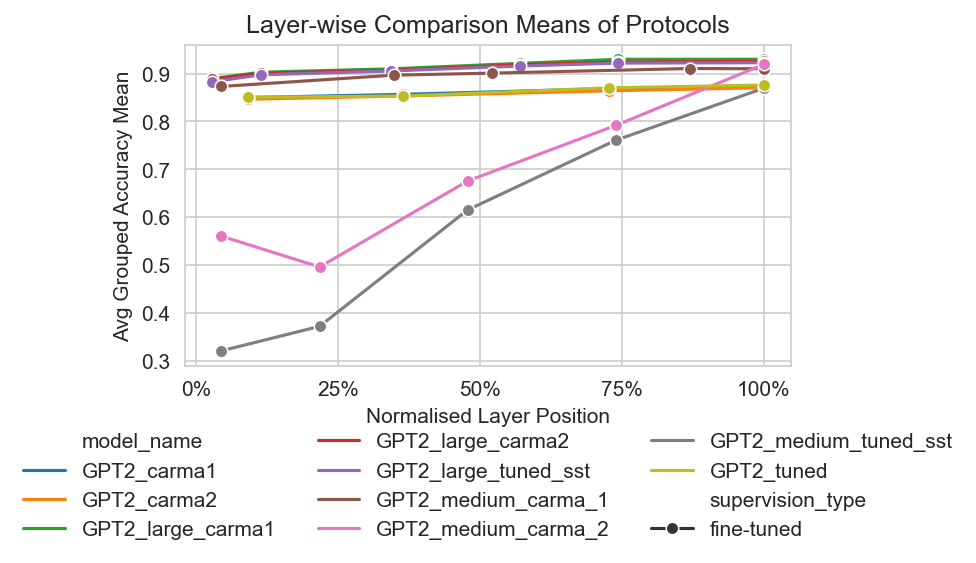

In [810]:
averaged_metrics_df = average_protocols(metrics_df)
averaged_metrics_df_sample = average_protocols(metrics_df_sample)
averaged_metrics_df_idm = average_protocols(metrics_df_idm)
averaged_metrics_df_sst = average_protocols(metrics_df_sst)
normalised_averaged_metrics_df = normalize_layers(averaged_metrics_df)
normalised_averaged_metrics_df_sample = normalize_layers(averaged_metrics_df_sample)
normalised_metrics_df_idm = normalize_layers(averaged_metrics_df_idm)
normalised_metrics_df_sst = normalize_layers(averaged_metrics_df_sst)
plot_normalized_layers(normalised_metrics_df_sst, metric='avg_grouped_accuracy_mean', task_type='inverse_dictionary', grouping_protocol=None)

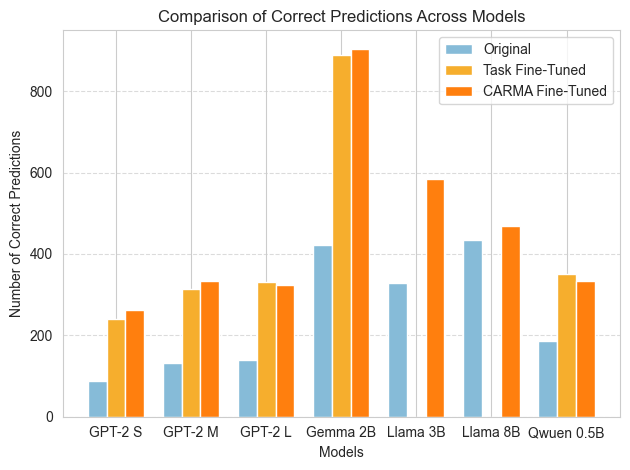

In [767]:
models = ['GPT-2 S', 'GPT-2 M', 'GPT-2 L', 'Gemma 2B', 'Llama 3B', 'Llama 8B', 'Qwuen 0.5B']
original = [87, 131, 140, 422, 329, 435, 186]
task_fine_tuned = [241, 315, 331, 888, 0,0,350]
all_fine_tuned = [261, 334, 324, 904, 583, 468, 334]
colors = ['#86BBD8', '#F6AE2D', '#ff7f0e']
output_file = 'idm_performance_comparison_plot.pdf'


create_grouped_bar_chart(models, original, task_fine_tuned, all_fine_tuned, colors, output_file)

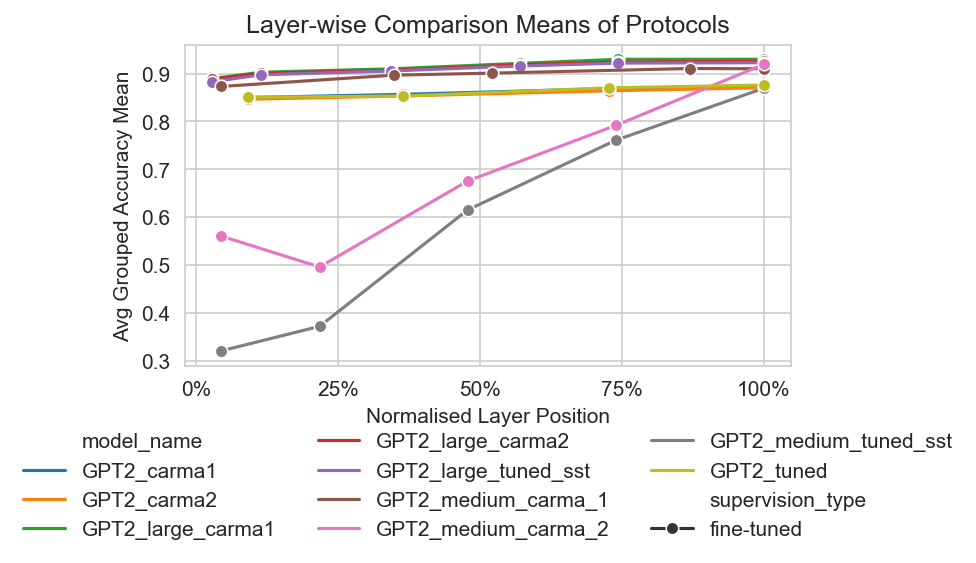

In [811]:
plot_normalized_layers(normalised_metrics_df_sst, metric='avg_grouped_accuracy_mean', task_type='inverse_dictionary',
                       grouping_protocol=None)

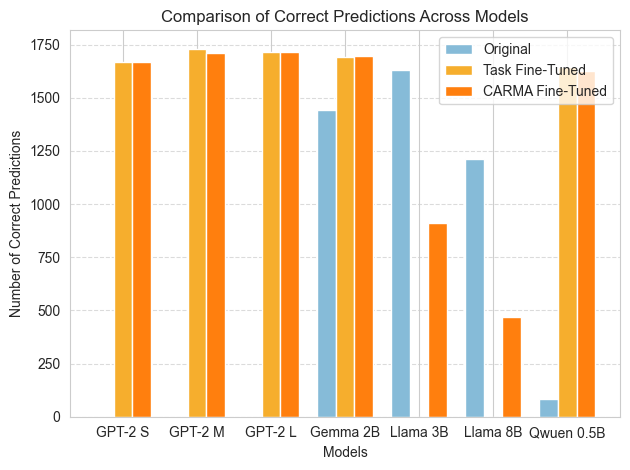

In [888]:
models = ['GPT-2 S', 'GPT-2 M', 'GPT-2 L', 'Gemma 2B', 'Llama 3B', 'Llama 8B', 'Qwuen 0.5B']
original = [0, 0, 0,  1443, 1631, 1211, 81]
task_fine_tuned = [ 1670, 1730, 1716, 1691, 0, 0, 1644]
all_fine_tuned = [ 1670, 1710, 1713, 1694, 909, 468, 1624]
colors = ['#86BBD8', '#F6AE2D', '#ff7f0e']
output_file = 'sst_performance_comparison_plot.pdf'

create_grouped_bar_chart(models, original, task_fine_tuned, all_fine_tuned, colors, output_file)